# Investigating Misclassifications (cont...)

In [5]:
import os
os.chdir('C:\Users\Lundi\Documents\Programming\Python\Kaggle\Digits')
#os.chdir('/Users/alexsutherland/Documents/Programming/Python/Kaggle/Digits')
import time

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
from sklearn.grid_search import GridSearchCV

classification_probability_data = pd.read_csv('Data/svc_classification_data.csv')

## Classification probabilites

First, I need to load the data:

In [2]:
digit_data = pd.read_csv('Data/train.csv')

X = digit_data.ix[:,1:digit_data.shape[1]]
y = digit_data['label']

Next, I will generate a prediction for each element in a subset of the full data. Furthermore, I need the prediction probabilities for these same samples. Therefore, I will run a custom cross-validation to get both of these:

## Predicting with prediction probabilities

Given the prediction probabilities, can I generate an AdaBoost tree model that will improve the prediction accuracy?

First, let's calculate the current CV accuracy:

In [6]:
np.mean(map(lambda prediction: 1 if prediction else 0, classification_probability_data['is_correct']))

0.9759523809523809

### Generating design matrix with prediction probabilities

In [7]:
X_pp = classification_probability_data.drop(['is_correct','Actual','Predicted'], axis=1)
y_pp = classification_probability_data['Actual']

X_pp_train, X_pp_test, y_pp_train, y_pp_test = skl_cv.train_test_split(X_pp, y_pp, test_size = 0.2)

In [8]:
import sklearn.ensemble as skl_ensemble
import sklearn.tree as skl_tree

dt_stump_clf = skl_tree.DecisionTreeClassifier(max_depth=1)
dt_clf = skl_tree.DecisionTreeClassifier()

#### Base Estimator accuracy

In [9]:
accuracy_dt_stump = np.mean(skl_cv.cross_val_score(dt_stump_clf, X_pp, y_pp, cv=5))
accuracy_dt_stump

0.2146430070143801

This is a terrible accuracy. Let's see if we can tune it to improve the model:

In [11]:
param_grid = [
    {'criterion': ['gini'], 'max_depth': [None,1,2,3,4,5,6], 'min_samples_leaf': [1,2,3,4]},
    {'criterion': ['entropy'], 'max_depth': [None,1,2,3,4,5,6], 'min_samples_leaf': [1,2,3,4]}
]

dt_gs_clf = GridSearchCV(estimator=dt_clf, param_grid = param_grid, cv=10)
dt_gs_clf.fit(X_pp, y_pp)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['entropy'], 'max_depth': [None, 1, 2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [13]:
for params, mean_score, scores in dt_gs_clf.grid_scores_:
    print mean_score, params

0.9615 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}
0.963404761905 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2}
0.966738095238 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3}
0.967761904762 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4}
0.214833333333 {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1}
0.214833333333 {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 2}
0.214833333333 {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 3}
0.214833333333 {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 4}
0.316380952381 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1}
0.316380952381 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
0.316380952381 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3}
0.316380952381 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 4}
0.413714285714 {'criterion': 'entropy', 'max_dep

This shows that the model really needs a deep depth to get predictions correct. Let's hash this out a bit more:

In [14]:
param_grid_max_depth = [
    {'criterion': ['entropy'], 'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]}
]

dt_gs_max_depth_clf = GridSearchCV(estimator=dt_clf, param_grid = param_grid_max_depth, cv=10)
dt_gs_max_depth_clf.fit(X_pp, y_pp)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [16]:
dt_gs_max_depth_results_list = []
for params, mean_score, scores in dt_gs_max_depth_clf.grid_scores_:
    print mean_score, params
    dt_gs_max_depth_results_list.append([mean_score, params['max_depth']])
dt_gs_max_depth_results_df = pd.DataFrame(dt_gs_max_depth_results_list, columns=['mean_score','max_depth'])

0.214833333333 {'criterion': 'entropy', 'max_depth': 1}
0.316380952381 {'criterion': 'entropy', 'max_depth': 2}
0.413714285714 {'criterion': 'entropy', 'max_depth': 3}
0.510857142857 {'criterion': 'entropy', 'max_depth': 4}
0.606476190476 {'criterion': 'entropy', 'max_depth': 5}
0.700952380952 {'criterion': 'entropy', 'max_depth': 6}
0.793785714286 {'criterion': 'entropy', 'max_depth': 7}
0.883666666667 {'criterion': 'entropy', 'max_depth': 8}
0.972571428571 {'criterion': 'entropy', 'max_depth': 9}
0.969119047619 {'criterion': 'entropy', 'max_depth': 10}
0.970738095238 {'criterion': 'entropy', 'max_depth': 11}
0.969571428571 {'criterion': 'entropy', 'max_depth': 12}
0.966261904762 {'criterion': 'entropy', 'max_depth': 13}
0.966761904762 {'criterion': 'entropy', 'max_depth': 14}
0.965452380952 {'criterion': 'entropy', 'max_depth': 15}
0.965428571429 {'criterion': 'entropy', 'max_depth': 16}
0.964261904762 {'criterion': 'entropy', 'max_depth': 17}


Plotting this

(0.9, 1)

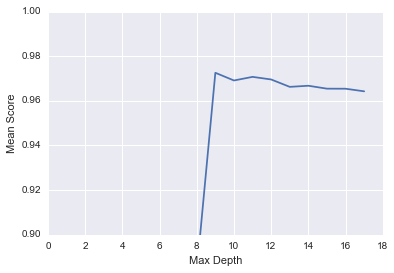

In [21]:
plt.plot(dt_gs_max_depth_results_df['max_depth'], dt_gs_max_depth_results_df['mean_score'])
ax = plt.gca()
ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean Score')
ax.set_ylim([0.9,1])

So this shows that a decision tree with a maximum of 9 splits works the best. This makes some sense because there are 10 numbers and each one should need a split before the model can be accurate. 

Let's apply this to bagging first:

## Bagging with DTs

In [25]:
bagging_clf = skl_ensemble.BaggingClassifier(
    base_estimator=dt_gs_max_depth_clf.best_estimator_,
    n_estimators=10
)
mean_error_10 = np.mean(skl_cv.cross_val_score(bagging_clf, X_pp, y_pp, cv=5))

bagging_clf = skl_ensemble.BaggingClassifier(
    base_estimator=dt_gs_max_depth_clf.best_estimator_,
    n_estimators=100
)
mean_error_100 = np.mean(skl_cv.cross_val_score(bagging_clf, X_pp, y_pp, cv=5))

#bagging_gf_clf = GridSearchCV(bagging_clf, param_grid = [{'n_estimators': [10,100,1000,5000]}], cv=10)
#bagging_gf_clf.fit(X_pp, y_pp)

In [26]:
mean_error_100

0.97535732865935942

In [27]:
mean_error_10

0.97483370325011087

So bagging does not improve upon the 0.975 baseline from the level-0 model

#### AdaBoost DT Model

In [28]:
ada_dt_stump_clf = skl_ensemble.AdaBoostClassifier(
    base_estimator=dt_gs_max_depth_clf.best_estimator_,
    n_estimators=300,
    learning_rate=0.1
)
ada_dt_stump_clf.fit(X_pp_train, y_pp_train)

ada_dt_stump_staged_accuracies = []
for index, y_pred in enumerate(ada_dt_stump_clf.staged_predict(X_pp_test)):
    current_accuracy = np.mean(y_pred == y_pp_test)
    ada_dt_stump_staged_accuracies.append([index, current_accuracy])
    ada_dt_stump_clf

ada_dt_stump_staged_accuracies = pd.DataFrame(ada_dt_stump_staged_accuracies, columns=['Stage', 'Accuracy'])

Plotting the staged accuracy of the DT

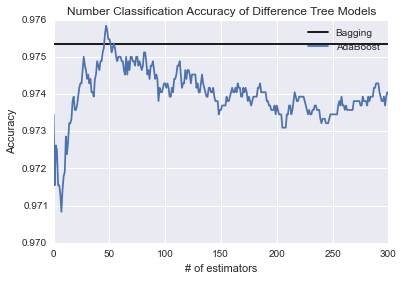

In [31]:
plt.axhline(mean_error_100, color='black')
plt.plot(ada_dt_stump_staged_accuracies['Stage'], ada_dt_stump_staged_accuracies['Accuracy'])
ax = plt.gca()
#ax.set_ylim([0,1])
ax.legend(['Bagging', 'AdaBoost'])
ax.set_xlabel('# of estimators')
ax.set_ylabel('Accuracy')
ax.set_title('Number Classification Accuracy of Difference Tree Models')    

So AdaBoost only improves upon the Bagging model briefly before it falls below. 